# TRIAL
This Notebook is used to train a ResNet-50 model on Amazon Planet Dataset (MultiLabel Classification Problem)

Used Fast AI for eaiser training and inference rather than PyTorch or Tensorflow

In [26]:
from fastai.vision.all import *
import pandas as pd
 

In [14]:
path = Path('/home/idisc02/Downloads/SATELLITE _PRACTICE')

In [ ]:
 
IMG_PATH = 'train-jpg/' #TRAINNED IMAGES
 
LABELS_PATH = 'train_v2.csv'# LABEL

## Loading and Visualizing Dataset

In [19]:
train_df = pd.read_csv('train_v2.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


Setting up data loading using Fastai's dataloaders. This function prepares the data for training by defining how the images and labels are loaded and transformed

In [20]:
def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=ColReader(0, pref=f'{path}/train-jpg/', suff='.jpg'),
                       get_y=ColReader(1, label_delim=' '),
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

In [21]:
dls = get_data(128,256)

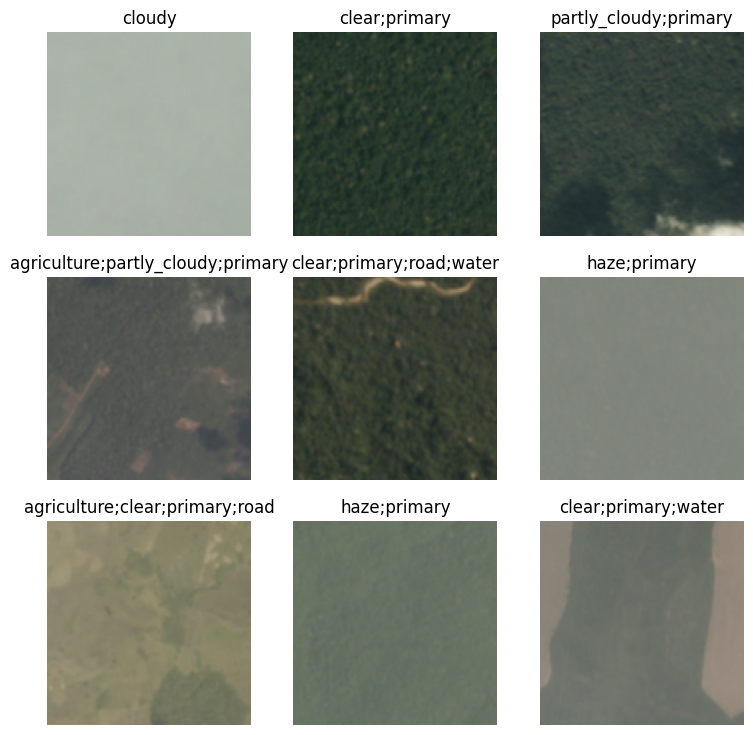

In [41]:
dls.show_batch()

## Train & Save ResNet-50 Model

In [23]:
metrics = [partial(accuracy_multi, thresh=0.2), FBetaMulti(beta=2, average='samples', thresh=0.2)]
cbs = [MixUp]

/home/idisc02/anaconda3/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/idisc02/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/idisc02/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/idisc02

SuggestedLRs(valley=0.0006918309954926372)

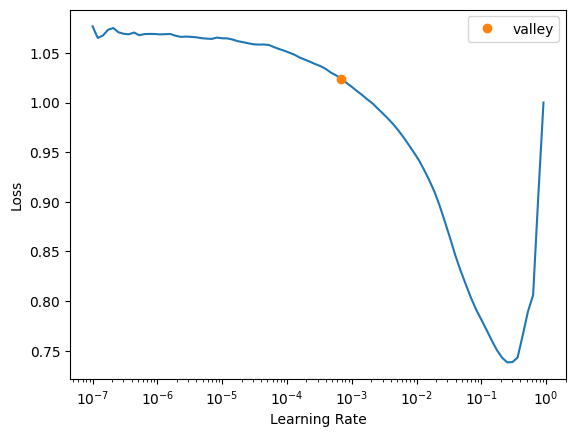

In [24]:
learn = cnn_learner(dls, resnet50, metrics=metrics, cbs=cbs).to_fp16()
learn.lr_find()

In [25]:
learn.fine_tune(6, base_lr=2e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.363888,0.136838,0.934862,0.875579,00:22
1,0.189280,0.116891,0.939411,0.900307,00:22
2,0.166453,0.109737,0.948588,0.908031,00:22
3,0.155953,0.107585,0.948509,0.911136,00:22


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.148903,0.105392,0.935647,0.907375,00:28
1,0.145868,0.097314,0.950892,0.915137,00:28
2,0.141908,0.096579,0.949054,0.916335,00:28
3,0.137121,0.092749,0.951146,0.921770,00:29
4,0.132822,0.085940,0.958224,0.926986,00:28
5,0.129241,0.086185,0.957498,0.926521,00:28


In [27]:
learn.save('resnet50-128')

Path('models/resnet50-128.pth')

## Results of the Model

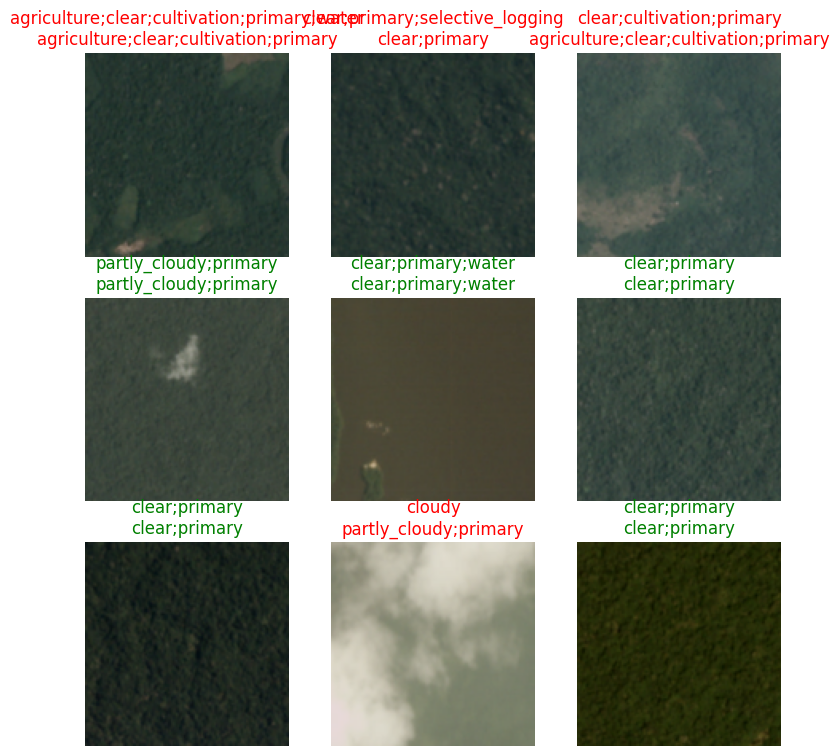

In [28]:
learn.show_results()

## Prediction and Inference of the Model

In [22]:
learn.export() # if we want .pkl file for proper end to end deployment (file will be saved as export.pkl)

In [27]:
#inference = learn.load('resnet50-128')

In [39]:
additional_test_path = Path('/home/idisc02/Downloads/SATELLITE _PRACTICE/test-jpg-additional')
test_path = Path('/home/idisc02/Downloads/SATELLITE _PRACTICE/test-jpg')
submission_df = pd.read_csv('/home/idisc02/Downloads/SATELLITE _PRACTICE/sample_submission_v2.csv/sample_submission_v2.csv')
testing_path = (submission_df['image_name'] + '.jpg').apply(lambda x: test_path/x if x.startswith('test') else additional_test_path/x)

def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl = tst_dl)
    else:
        predictions = learn.get_preds(dl = tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

In [40]:
prediction('submission_tta.csv', tta=True)

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear partly_cloudy primary
4,test_4,cloudy partly_cloudy primary
...,...,...
61186,file_9995,cloudy partly_cloudy primary
61187,file_9996,clear primary water
61188,file_9997,clear primary road
61189,file_9998,cloudy


#  EfficientNet

/home/idisc02/anaconda3/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/idisc02/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/idisc02/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman

SuggestedLRs(valley=0.0012022644514217973)

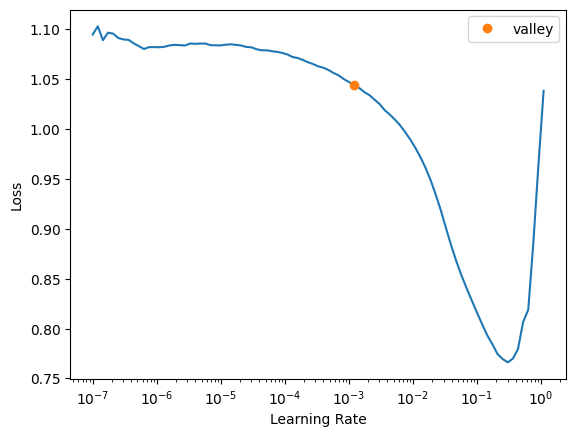

In [43]:
from fastai.vision.all import *

 

# Specify the EfficientNet variant you want to use (e.g., efficientnet_b0)
efficientnet_variant = efficientnet_b0

# Create a cnn_learner using EfficientNet architecture
learn = cnn_learner(dls, efficientnet_variant, metrics=metrics, cbs=cbs).to_fp16()

# Find the optimal learning rate
learn.lr_find()


In [44]:
learn.fine_tune(6, base_lr=2e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.383987,0.162566,0.925728,0.841340,00:18
1,0.204774,0.139386,0.922479,0.871806,00:18
2,0.177411,0.131470,0.932035,0.873298,00:18
3,0.166510,0.119765,0.935632,0.894817,00:18


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.156106,0.109282,0.943073,0.905180,00:22
1,0.153280,0.103987,0.946161,0.909006,00:22
2,0.149653,0.099566,0.945413,0.914293,00:22
3,0.145678,0.097697,0.946692,0.915374,00:22
4,0.141970,0.095949,0.952149,0.918683,00:22
5,0.141175,0.096088,0.950703,0.917544,00:22


In [45]:
learn.save('efficientnet_b0')

Path('models/efficientnet_b0.pth')

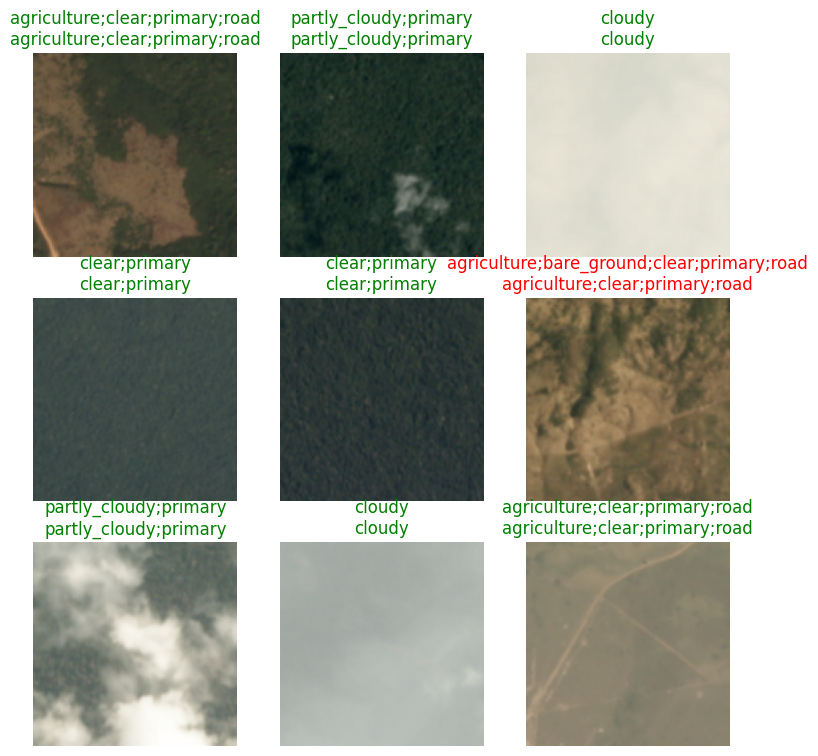

In [46]:
learn.show_results()

In [47]:
learn.export() # if we want .pkl file for proper end to end deployment (file will be saved as export.pkl)

In [48]:
additional_test_path = Path('/home/idisc02/Downloads/SATELLITE _PRACTICE/test-jpg-additional')
test_path = Path('/home/idisc02/Downloads/SATELLITE _PRACTICE/test-jpg')
submission_df = pd.read_csv('/home/idisc02/Downloads/SATELLITE _PRACTICE/sample_submission_v2.csv/sample_submission_v2.csv')
testing_path = (submission_df['image_name'] + '.jpg').apply(lambda x: test_path/x if x.startswith('test') else additional_test_path/x)

def prediction(filename='submission2.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl = tst_dl)
    else:
        predictions = learn.get_preds(dl = tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

In [49]:
prediction('submission2_tta.csv', tta=True)

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear partly_cloudy primary
4,test_4,partly_cloudy primary
...,...,...
61186,file_9995,cloudy partly_cloudy primary
61187,file_9996,clear primary water
61188,file_9997,clear primary road water
61189,file_9998,cloudy


In [ ]:
VGG (Visual Geometry Group) 